<a href="https://colab.research.google.com/github/OmarEldeeb98/Arabic-Hate-Speech-Recognition/blob/main/SSP_CCE_Proj2_20202021_Hate_Speech_Detection_Neural_Learning_Models_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate speech Detection using CNN
In this notebook, we conduct a preliminary experiment on the detection of hate speech in Arabic tweets as part of our participation in the Hate Speech Detection subtask in [OSACT4 workshop](http://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/).




In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)


# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [ ]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/My Drive/tweets_sg_300.zip'  

Archive:  /content/drive/My Drive/tweets_sg_300.zip
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [ ]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/train_data.csv')
train_data

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6995,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6996,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6997,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6998,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [ ]:
dev_data = pd.read_csv('/content/drive/My Drive/dev_data.csv')
dev_data

,Tweet,Offensive,Hate
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS
...,...,...,...
995,RT @USER: انتو بتوزعوا زيت وسكر فعلا يا عباس؟<...,NOT_OFF,NOT_HS
996,RT @USER: كدا يا عمر متزعلهاش يا حبيبي 😂 URL,NOT_OFF,NOT_HS
997,هدا سكن اطفال امارتين من شارقة طالبين فزعتكم ي...,NOT_OFF,NOT_HS
998,RT @USER: ومدني بمدد من قوتك أواجه به ضعفي.. و...,NOT_OFF,NOT_HS


In [ ]:
print("Train data shape: {} \nDev data shape: {}".format(train_data.shape,dev_data.shape))


Train data shape: (7000, 3) 
Dev data shape: (1000, 3)


In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/Test_data.csv')
test_data

,Tweet,Offensive,Hate
0,@USER اما انت تقعد طول عمرك لا مبدا ولا راي ثا...,OFF,HS
1,@USER @USER بتخاف نسوانك يزعلوا ولا ايه 😂 اه ي...,OFF,NOT_HS
2,RT @USER: يا عـسانـى نـبـقى يا عـمري حـبايـب و...,NOT_OFF,NOT_HS
3,RT @USER: باقي البيان وينو ما شفنه يا برهان <L...,OFF,NOT_HS
4,@USER @USER اللهم انت الشافي المعافي اشفيه وجم...,NOT_OFF,NOT_HS
...,...,...,...
1995,RT @USER: الله لايوفقك يا مهند عسيري يا معوق و...,OFF,NOT_HS
1996,RT @USER: @USER حبيبي يا يوسف وانت طيب يا صاحب...,NOT_OFF,NOT_HS
1997,RT @USER: يا بو محمد عشت يا طيب الفال<LF>عاشت ...,NOT_OFF,NOT_HS
1998,أنا مستني الحلقة بقالي سنتين يا بضان يا ابن ال...,OFF,NOT_HS


In [ ]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[2].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, dev_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    dev_tokenized = tokenizer.texts_to_sequences(dev_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(dev_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train,x_dev, x_test, y_train,y_dev, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_dev = y_encoder.transform(y_dev)
    y_test = y_encoder.transform(y_test)

    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_dev, x_vec_test, word_index = get_train_test(x_train,x_dev, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of dev examples: ' + str(len(x_vec_test)))
    return x_vec_train,x_vec_dev, x_vec_test, y_train, y_dev, y_test, train_y_cat, word_index


In [ ]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

Number of words in the word embedding 331679


In [ ]:
# load train data
train_data_path=["/content/drive/My Drive/synonyms_remove.csv"]
x_train, y_train, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 84
Label categories: ['HS' 'NOT_HS']


In [ ]:
# load dev data
dev_data_path=["/content/drive/My Drive/dev_data_cleaned.csv"]
x_dev, y_dev, MAX_TEXT_LENGTH = load_datasets(dev_data_path)
CLASSES_LIST = np.unique(y_dev)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 72
Label categories: ['HS' 'NOT_HS']


In [ ]:
# load test data
test_data_path=["/content/drive/My Drive/test_data_cleaned.csv"]
x_test, y_test, MAX_TEXT_LENGTH = load_datasets(test_data_path)
CLASSES_LIST = np.unique(y_test)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 72
Label categories: ['HS' 'NOT_HS']


In [ ]:
MAX_TEXT_LENGTH=84

In [ ]:
x_train, x_dev,x_test, y_train, y_dev, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_dev,x_test, 
                                                                            y_train, y_dev,y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
dev_cat_y = np_utils.to_categorical(y_dev, len(CLASSES_LIST))
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 9002
Number of dev examples: 2000


In [ ]:
print("Tokens number: "+str(len(word_index)))

Tokens number: 30591


In [ ]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))


Original sequence length: 84


#  CNN model building:

In [ ]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)

    model = Conv1D(filters=25, kernel_size=5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
   
    model = Dense(2, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    from keras import optimizers

    opt = optimizers.Adam(lr=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_dev, y_train, y_dev, batch_size, epochs, TestCallback=TestCallback):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_dev, y_dev),
                        callbacks=[TestCallback((x_dev, y_dev)),early_stopping])
    return history, model

In [ ]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 84)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 84, 300)           9177600   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 84, 25)            37525     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 42, 25)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1050)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2102      
Total params: 9,217,227
Trainable params: 39,627
Non-trainable params: 9

In [ ]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y,
                               batch_size=500, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
19/19 [==============================] - 7s 358ms/step - loss: 0.7417 - accuracy: 0.3459 - val_loss: 0.6089 - val_accuracy: 0.7480

Testing loss: 0.6089228391647339, acc: 0.7480000257492065

Epoch 2/20
19/19 [==============================] - 7s 348ms/step - loss: 0.6524 - accuracy: 0.6713 - val_loss: 0.5241 - val_accuracy: 0.9460

Testing loss: 0.5240951180458069, acc: 0.9459999799728394

Epoch 3/20
19/19 [==============================] - 7s 344ms/step - loss: 0.6175 - accuracy: 0.7307 - val_loss: 0.4660 - val_accuracy: 0.9550

Testing loss: 0.4659693241119385, acc: 0.9549999833106995

Epoch 4/20
19/19 [==============================] - 7s 346ms/step - loss: 0.5862 - accuracy: 0.7331 - val_loss: 0.4312 - val_accuracy: 0.9550

Testing loss: 0.4311663508415222, acc: 0.9549999833106995

Epoch 5/20
19/19 [==============================] - 7s 348ms/step - loss: 0.5620 - accuracy: 0.7397 - val_loss: 0.3997 - val_accuracy: 0.9550

Testing loss: 0.39972567558288574, acc: 0.9549999

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)


1/1 [==============================] - 0s 246ms/step - loss: 0.2157 - accuracy: 0.9430


[0.21568898856639862, 0.9430000185966492]

In [ ]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=3))

              precision    recall  f1-score   support

          HS      0.333     0.295     0.313        44
      NOT_HS      0.968     0.973     0.970       956

    accuracy                          0.943      1000
   macro avg      0.651     0.634     0.642      1000
weighted avg      0.940     0.943     0.941      1000



In [ ]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

2/2 [==============================] - 1s 235ms/step - loss: 0.2266 - accuracy: 0.9415


[0.22664254903793335, 0.9415000081062317]

In [ ]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=3))

              precision    recall  f1-score   support

          HS      0.405     0.337     0.368       101
      NOT_HS      0.965     0.974     0.969      1899

    accuracy                          0.942      2000
   macro avg      0.685     0.655     0.668      2000
weighted avg      0.937     0.942     0.939      2000



In [ ]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 18
Accuracy on train : 84.03 %
Accuracy on val : 95.4 %
Loss on train : 34.17
Loss on Val : 20.77


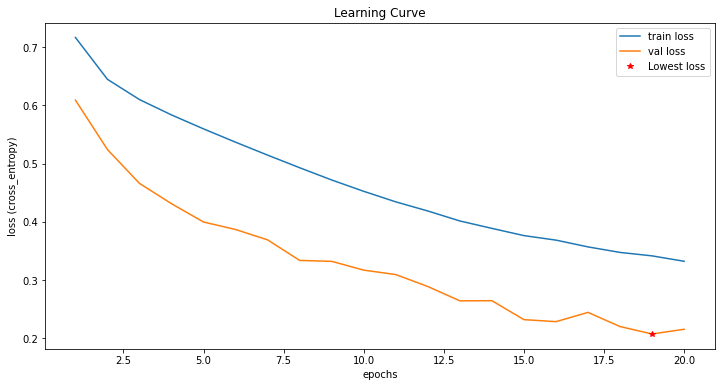

In [ ]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

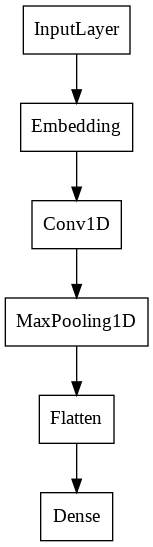

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)